In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [4]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [5]:
fname = '09/frame_00667_rgb.jpg'

In [6]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

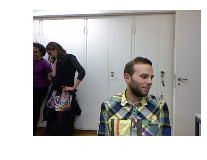

In [7]:
img = open_image(path/fname)
img.show()

In [8]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [9]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [10]:
get_ctr(fname)

tensor([263.9104, 428.5814])

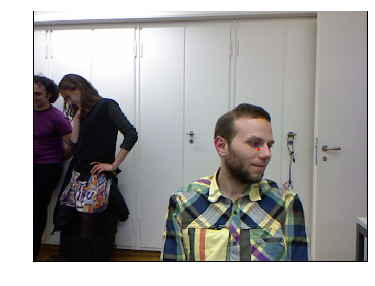

In [11]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

In [12]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

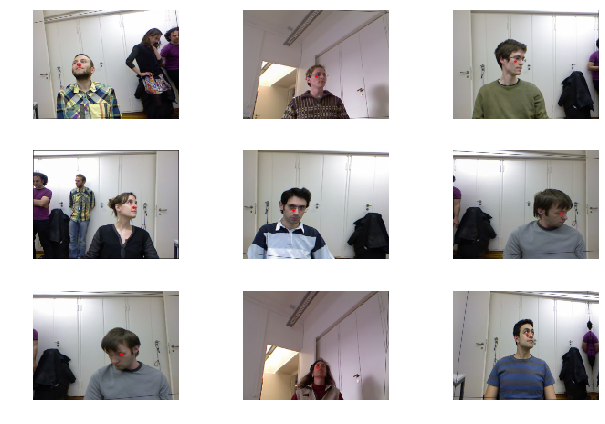

In [13]:
data.show_batch(3, figsize=(9,6))

In [14]:
learn = cnn_learner(data, models.resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 112620458.38it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


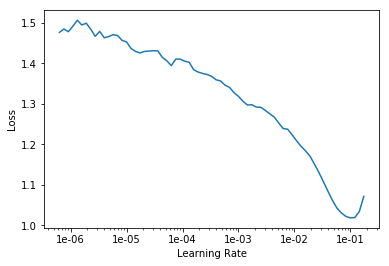

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
lr = 2e-2

In [17]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,time
0,0.055055,0.005698,02:48
1,0.014881,0.003069,02:45
2,0.008226,0.001304,02:45


In [18]:
learn.save('/kaggle/working/stage-1')

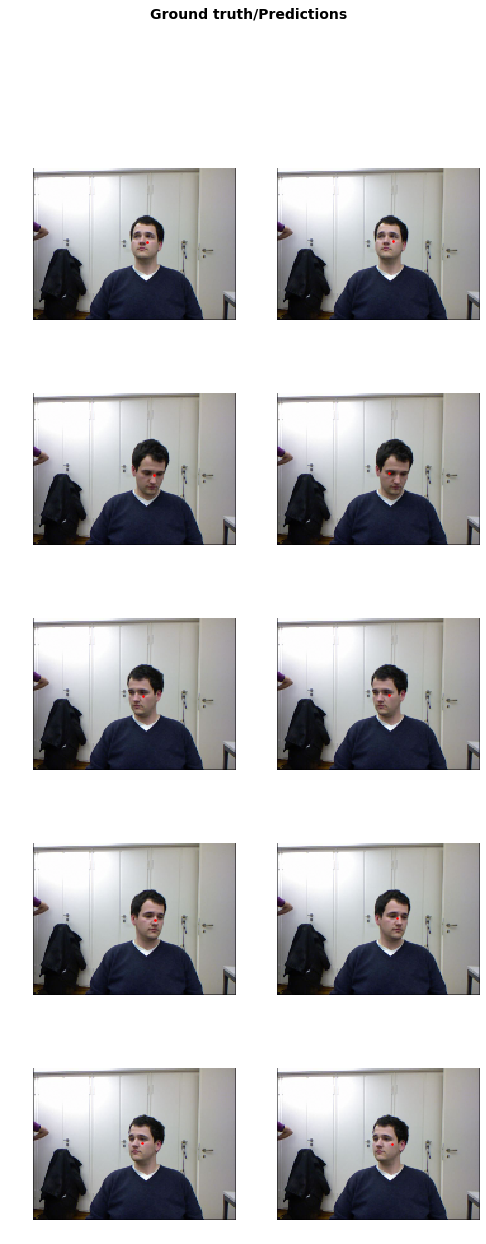

In [19]:
learn.show_results()

In [20]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

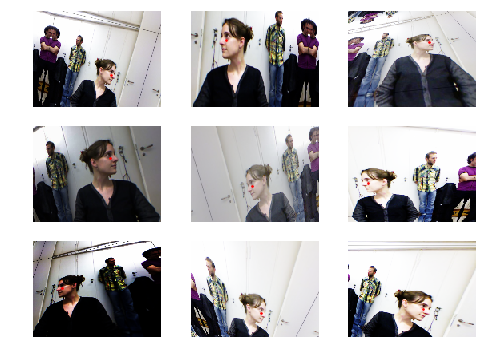

In [21]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))